In [1]:
from datetime import datetime
import time

import gdax
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
order_book = gdax.OrderBook(product_id='BTC-USD')

In [3]:
order_book.start()
time.sleep(10)
order_book.close()

-- Subscribed to OrderBook! --


-- OrderBook Socket Closed! --


In [4]:
order_book.get_current_book()['bids'][-1]

[Decimal('6683.99000000'),
 Decimal('0.06500000'),
 '42307def-0239-4fd6-8a65-18a781f95cc7']

CPU times: user 180 ms, sys: 3.09 ms, total: 183 ms
Wall time: 182 ms


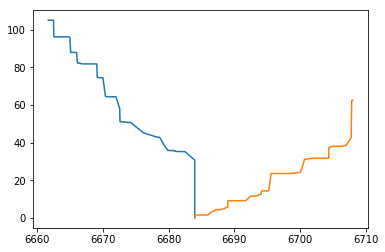

In [5]:
%%time

NUM_LEVELS = 64

def aggregate(orders, is_bid):
    dfreq = {}
    for dp, dv, _ in orders:
        sp = str(dp)
        v = np.float(dv)
        if sp in dfreq:
            dfreq[sp] += v
        else:
            dfreq[sp] = v
    
    lfreq = list(dfreq.items())
    lfreq = [(np.float(p), v) for p, v in lfreq]
    lfreq.sort()
    
    if is_bid:
        return np.asarray(lfreq[-NUM_LEVELS:])
    else:
        return np.asarray(lfreq[:NUM_LEVELS])

def get_vols(order_book):
    cur_book = order_book.get_current_book()
    bid_vols = aggregate(cur_book['bids'], True)
    ask_vols = aggregate(cur_book['asks'], False)
    return bid_vols, ask_vols

bv, av = get_vols(order_book)
plt.plot(bv[:, 0], bv[:, 1].sum() - bv[:, 1].cumsum())
plt.plot(av[:, 0], av[:, 1].cumsum())

In [6]:
sz = int(50)
bid_record = np.zeros((sz, NUM_LEVELS, 2))
ask_record = np.zeros((sz, NUM_LEVELS, 2))
time_record = np.zeros(sz)
print("Will last", sz / 60.0 / 60, "hours")

Will last 0.01388888888888889 hours


In [7]:
def record_order_book(idx, order_book, t):
    bv, av = get_vols(order_book)
    bid_record[idx] = bv
    ask_record[idx] = av
    time_record[idx] = t

In [8]:
%%time
record_order_book(0, order_book, time.time())

CPU times: user 162 ms, sys: 2.62 ms, total: 165 ms
Wall time: 164 ms


In [9]:
order_book.start()
print("Doing initial sleep...")
time.sleep(10)
print("Collecting data...")

TIME_STEP = 0.5
print("Recording order_book every {} seconds".format(TIME_STEP))
try:
    idx = 0
    while idx < sz:
        beg_time = time.time()
        record_order_book(idx, order_book, time.time())
        if idx % 20 == 0:
            print(idx)
        idx = idx + 1
        end_time = time.time()
        elapsed_time = end_time - beg_time
        time.sleep(max(TIME_STEP - elapsed_time, 0))
except KeyboardInterrupt as e:
    order_book.close()
    raise(e)

-- Subscribed to OrderBook! --

Doing initial sleep...
Recording order_book every 0.5 seconds
0
20
40


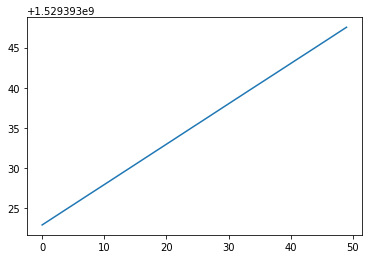

In [10]:
plt.plot(time_record)

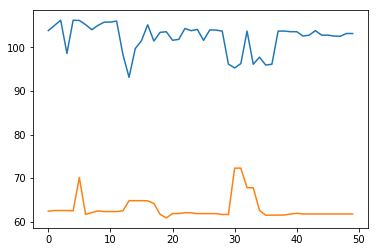

In [11]:
plt.plot(bid_record[:,:,1].sum(axis=1))
plt.plot(ask_record[:,:,1].sum(axis=1))

In [12]:
np.save('data/bid_record.npy', bid_record)
np.save('data/ask_record.npy', ask_record)
np.save('data/time_record.npy', time_record)